In [30]:
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm
from scipy.signal import detrend

# Custom package
sys.path.append('/home/rrp000/sea_ice/code/')
from icepack import get_dataset
from icepack.analysis import *
from icepack.splot import *
from icepack.skill import *

# Some useful lists and dicts
monthletters = ['J','F','M','A','M','J','J','A','S','O','N','D']
monthstr = ['01','02','03','04','05','06','07','08','09','10','11','12']
monthdict = {1:r'$\mathbf{January}$',
             2:r'$\mathbf{February}$',
             3:r'$\mathbf{March}$',
             4:r'$\mathbf{April}$',
             5:r'$\mathbf{May}$',
             6:r'$\mathbf{June}$',
             7:r'$\mathbf{July}$',
             8:r'$\mathbf{August}$',
             9:r'$\mathbf{September}$',
             10:r'$\mathbf{October}$',
             11:r'$\mathbf{November}$',
             12:r'$\mathbf{December}$'}

method = 'mean'
daterange = (2000,2019)
daterange_clim = (1992,2015)

grid_path = "~/sea_ice/data/grids/grid_1x1.nc"
grid = xr.open_dataset(grid_path)

cmap = colors.ListedColormap(loadmat('../cmaps/cmap_jet3.mat')['cmap'], name='jet3')

In [2]:
# open data
sic = get_dataset('Had2CIS')

# calculate SIE and anomalies
sie_Had2CIS = get_iceextent(sic, grid, lat_bounds=(-90,0), sic_label='sicn', lat_label='lat', lon_label='lon', ensemble=None)
sie_anom_Had2CIS = get_anomalies(sie_Had2CIS,'SIE',ref_period=daterange)
sie_clim_Had2CIS = get_climatology(sie_Had2CIS,var='SIE',ref_period=daterange_clim)

/home/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:


In [31]:
# CELL TAKES ~1 MINUTE TO RUN

# open data and format time
sic_CanESM5_init = get_dataset('CanESM5.0_i')
sic_CanESM5_init = [format_time_coord(data,f'1981-{monthstr[i]}',f'202{int(np.heaviside(i,0))}-{monthstr[i-1]}',freq='M') for i,data in enumerate(sic_CanESM5_init)]

# calculate SIE (ensemble mean) and SIE anomalies
print("Calculating SIE")
sie_CanESM5_init = []
for i,sic in enumerate(sic_CanESM5_init):
    sie_CanESM5_init.append(get_iceextent(sic, grid, lat_bounds=(-90,0), sic_label='siconc', lat_label='lat', lon_label='lon', ensemble='mean', sic_factor=1e-2))
# sie_anom_CanESM5_init = [get_anomalies(sie,'SIE',ref_period=daterange) for sie in sie_CanESM5_init]
sie_anom_CanESM5_init = [remove_trend(sie,'SIE',ref_period=(1980,2010)) for sie in sie_CanESM5_init]

# add a lead time coordinate to the SIE data set
print("Adding a lead time coordinate")
for i in range(len(sie_CanESM5_init)):
    im = i + 1
    sie_CanESM5_init[i]['lead'] = (sie_CanESM5_init[i]['time.month'] - im)%12
    sie_anom_CanESM5_init[i]['lead'] = (sie_anom_CanESM5_init[i]['time.month'] - im)%12

# re-sort by leadtime
sie_CanESM5_init_lt = [xr.merge([sie_CanESM5_init[im-1].where(sie_CanESM5_init[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]
sie_anom_CanESM5_init_lt = [xr.merge([sie_anom_CanESM5_init[im-1].where(sie_anom_CanESM5_init[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]

# Calculate climatology
sie_clim_CanESM5_init = [get_climatology(sie,var='SIE',ref_period=daterange_clim) for sie in sie_CanESM5_init_lt]

Calculating SIE


/home/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:
/home/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.dims == {'lon':360, 'lat':180}:
/home/rrp000/sea_ice/code/icepack/analysis.py:152: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if grid_area.

Adding a lead time coordinate


In [32]:
sie_dt_Had2CIS = remove_trend(sie_Had2CIS,'SIE',ref_period=(1980,2010))
sie_dt_CanESM5_init_lt = sie_anom_CanESM5_init_lt#[remove_trend(sie.drop_vars('lead'),'SIE',ref_period=(1980,2010)) for sie in sie_CanESM5_init_lt]

In [39]:
skill_CanESM5, sig_CanESM5 = get_skillmatrix(sie_Had2CIS,sie_CanESM5_init_lt,daterange=(1980,2019),significance_test=True)
skill_CanESM5_dt, sig_CanESM5_dt = get_skillmatrix(sie_dt_Had2CIS,sie_dt_CanESM5_init_lt,daterange=(1980,2019),significance_test=True)

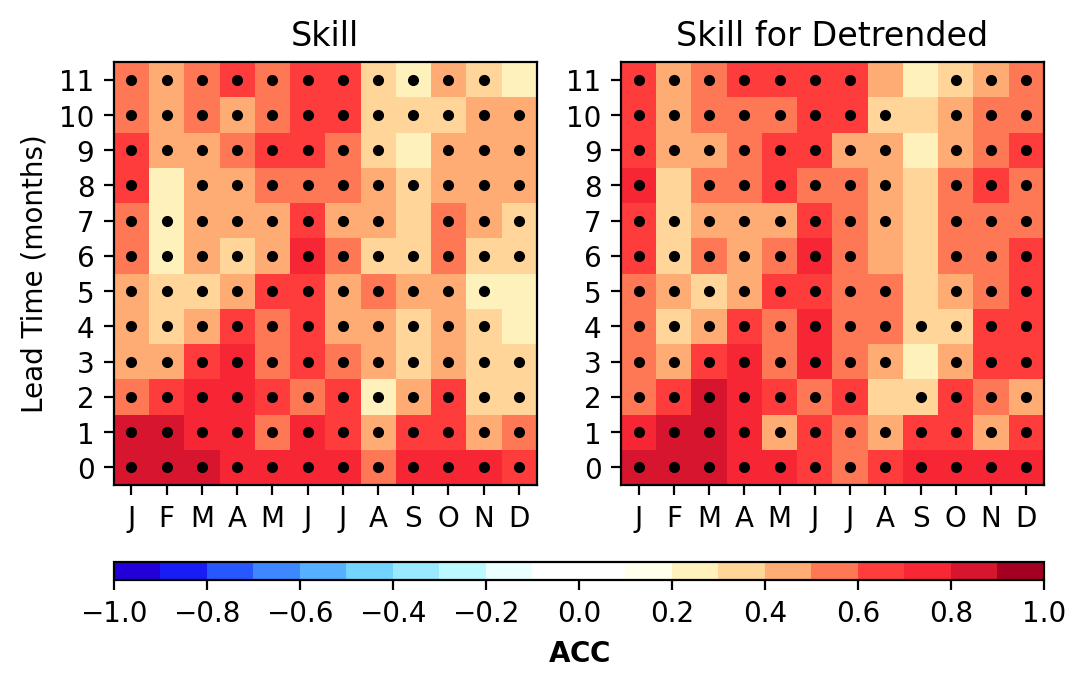

In [40]:
fix,ax = plt.subplots(1,2, figsize=(6,5),dpi=200)

skill_plot = ax[0].imshow(skill_CanESM5,cmap=cmap)
for lead in range(12):
    for tm in np.arange(1,13):
        if sig_CanESM5[lead][tm-1] == True:
            ax[0].plot(tm-1,lead,'.',color='black')
ax[0].invert_yaxis()
ax[0].set_yticks(np.arange(12))
ax[0].set_xticks(np.arange(12))
ax[0].set_xticklabels(monthletters)
ax[0].set_ylabel('Lead Time (months)')
ax[0].set_title("Skill")


skill_plot2 = ax[1].imshow(skill_CanESM5_dt,cmap=cmap)
for lead in range(12):
    for tm in np.arange(1,13):
        if sig_CanESM5_dt[lead][tm-1] == True:
            ax[1].plot(tm-1,lead,'.',color='black')
ax[1].invert_yaxis()
ax[1].set_yticks(np.arange(12))
ax[1].set_xticks(np.arange(12))
ax[1].set_xticklabels(monthletters)
ax[1].set_ylabel(None)
ax[1].set_title("Skill for Detrended")

skill_plot.set_clim([-1.,1.])
skill_plot2.set_clim([-1.,1.])
cticks = np.linspace(-1.,1.,11)
cbar = plt.colorbar(skill_plot,ax=ax,aspect=50,shrink=1,ticks=cticks,location='bottom',pad=0.1,label=r"$\mathbf{ACC}$")

plt.show()